<a href="https://colab.research.google.com/github/YashChadha/AI_assignment_5/blob/main/MAB_Application_Text_Classification_with_Transformer_%26_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Runtime --> Change runtime type --> GPU

In [ ]:
!nvidia-smi

Wed Apr 19 15:56:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Recall the Sarcasm Detection Task

In [ ]:
import json
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/sarcasm.json \
    -O /tmp/sarcasm.json

--2023-04-19 15:56:53--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.127.128, 142.251.18.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  18.6MB/s    in 0.3s    

2023-04-19 15:56:54 (18.6 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [ ]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [ ]:
vocab_size = 10000
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In order to 'add up' the embeddings representing the individual words in a sentence we used a `tf.keras.layer` which simply takes the average. What if we use a more complex model with a greater potential for increased performance? A potential drawback of this model is the number of hyperparameters - how do we pick the best combination? 

Up until now we have been using a 'trial and error' approach with our hyperparameters. Let's try it again:

In [ ]:
# Hyperparameters
embedding_dim = 64
att_heads = 8
key_dim = 512
dropout = 0.1
batch_size = 128

Under the hood, ChatGPT uses a Transformer-based architecture. But we're not doing sequence-to-sequence translation or text generation so we don't need both an encoder and a decoder. 

This classification model is based on an encoder for a Transformer model. The encoder is used to learn useful representations from the input and then these representations are uses to generate a prediction on $\{0,1\}$.

In [ ]:
# Note: up until now the examples have used the Sequential API; this is considered the Functional API. 

input = tf.keras.Input(shape=max_length, name="Input")
emb = tf.keras.layers.Embedding(
    vocab_size, 
    embedding_dim, 
    input_length=max_length,
    name='Embedding')(input)
mhsa = tf.keras.layers.MultiHeadAttention(
    num_heads=att_heads, 
    key_dim=key_dim,
    name='MHA'
)
attn_out = mhsa(
    query=emb,
    value=emb,
    key=emb
)
attn_out = tf.keras.layers.Add(name='MHA_Add')([emb, attn_out])
attn_ln = tf.keras.layers.LayerNormalization(name='MHA_Norm')(attn_out)
dl = tf.keras.layers.Dense(embedding_dim, activation='relu', name="FF")(attn_ln)
dl = tf.keras.layers.Dropout(dropout, name='Dropout_Hidden')(dl)
dl_out = tf.keras.layers.Add(name='FF_Add')([attn_ln, dl])
dl_ln = tf.keras.layers.LayerNormalization(name='FF_Norm')(dl_out)
fltn = tf.keras.layers.Flatten(name='Flatten')(dl_ln)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='Predict')(fltn)

In [ ]:
model = tf.keras.Model(inputs=input, outputs=output, name="My_Model")

In [ ]:
model.summary()

Model: "My_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 100)]        0           []                               
                                                                                                  
 Embedding (Embedding)          (None, 100, 64)      640000      ['Input[0][0]']                  
                                                                                                  
 MHA (MultiHeadAttention)       (None, 100, 64)      1060928     ['Embedding[0][0]',              
                                                                  'Embedding[0][0]',              
                                                                  'Embedding[0][0]']              
                                                                                           

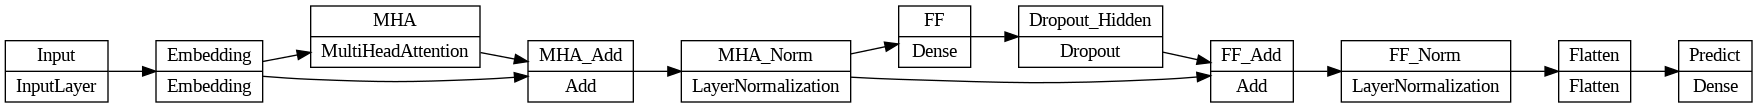

In [ ]:
tf.keras.utils.plot_model(model, rankdir='LR')

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
num_epochs = 10
history = model.fit(
    training_padded, 
    training_labels, 
    epochs=num_epochs, 
    batch_size=batch_size,
    validation_data=(testing_padded, testing_labels)
)

Epoch 1/10
157/157 [==============================] - 40s 194ms/step - loss: 0.7349 - accuracy: 0.5688 - val_loss: 0.4694 - val_accuracy: 0.7830
Epoch 2/10
157/157 [==============================] - 22s 142ms/step - loss: 0.2483 - accuracy: 0.8990 - val_loss: 0.3509 - val_accuracy: 0.8483
Epoch 3/10
157/157 [==============================] - 21s 131ms/step - loss: 0.0750 - accuracy: 0.9776 - val_loss: 0.3652 - val_accuracy: 0.8544
Epoch 4/10
157/157 [==============================] - 20s 131ms/step - loss: 0.0312 - accuracy: 0.9940 - val_loss: 0.4245 - val_accuracy: 0.8442
Epoch 5/10
157/157 [==============================] - 20s 126ms/step - loss: 0.0136 - accuracy: 0.9981 - val_loss: 0.4542 - val_accuracy: 0.8548
Epoch 6/10
157/157 [==============================] - 19s 119ms/step - loss: 0.0068 - accuracy: 0.9992 - val_loss: 0.4906 - val_accuracy: 0.8505
Epoch 7/10
157/157 [==============================] - 19s 124ms/step - loss: 0.0044 - accuracy: 0.9993 - val_loss: 0.5443 - val_ac

In [ ]:
max(history.history['val_accuracy'])

0.8548218607902527

Not bad for randomly choosing hyperparameters. The 'embeddings averaging' model only produced validation set accuracy that reached ~82%.

# Learn Hyperparameters using Bayesian Optimization
This is a complex model which, even on a Google Colab GPU, is costly (time consuming) to train. We don't want to simply guess, or use grid search, or random search - we would like to treat this as a Multi-Armed Bandit problem and balance the Exploration-Exploitation dilemma with some algorithmic efficiency.

https://github.com/fmfn/BayesianOptimization


Note that we will use a new technique: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
def train_and_eval(embedding_dim, att_heads, key_dim, dropout, batch_size):
    embedding_dim = int(embedding_dim)
    att_heads = int(att_heads)
    key_dim = int(key_dim)
    dropout = dropout
    batch_size = int(batch_size)

    input = tf.keras.Input(shape=max_length, name="Input")
    emb = tf.keras.layers.Embedding(
        vocab_size, 
        embedding_dim, 
        input_length=max_length,
        name='Embedding')(input)
    mhsa = tf.keras.layers.MultiHeadAttention(
        num_heads=att_heads, 
        key_dim=key_dim,
        name='MHA'
    )
    attn_out = mhsa(
        query=emb,
        value=emb,
        key=emb
    )
    attn_out = tf.keras.layers.Add(name='MHA_Add')([emb, attn_out])
    attn_ln = tf.keras.layers.LayerNormalization(name='MHA_Norm')(attn_out)
    dl = tf.keras.layers.Dense(embedding_dim, activation='relu', name="FF")(attn_ln)
    dl = tf.keras.layers.Dropout(dropout, name='Dropout_Hidden')(dl)
    dl_out = tf.keras.layers.Add(name='FF_Add')([attn_ln, dl])
    dl_ln = tf.keras.layers.LayerNormalization(name='FF_Norm')(dl_out)
    fltn = tf.keras.layers.Flatten(name='Flatten')(dl_ln)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='Predict')(fltn)

    model = tf.keras.Model(inputs=input, outputs=output, name="My_Model")

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    ### NEW
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=2,
        restore_best_weights=True
    )

    history = model.fit(
        training_padded, 
        training_labels, 
        epochs=num_epochs, 
        batch_size=batch_size,
        validation_data=(testing_padded, testing_labels),
        callbacks=[callback], ### NEW
        verbose=0
    )

    del model

    return max(history.history['val_accuracy'])

In [ ]:
!pip install bayesian_optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

# Your work here:

In [ ]:
!pip install scipy==1.7
from typing import Dict, Any

# Define the range of values for each hyperparameter
pbounds: Dict[str, Any] = {
    'embedding_dim': (50, 300),
    'att_heads': (2, 10),
    'key_dim': (10, 100),
    'dropout': (0.1, 0.7),
    'batch_size': (16, 128)
}

# Define the evaluation function for neural network performance
def evaluate_model(embedding_dim: int, att_heads: int, key_dim: int, dropout: float, batch_size: int) -> float:
    """
    Function to train and evaluate a neural network with the given hyperparameters.
    Returns the validation set accuracy.
    """
    return train_and_eval(embedding_dim, att_heads, key_dim, dropout, batch_size)

# Initialize the Bayesian Optimization algorithm
optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=pbounds,
    random_state=42,
)

# Initialize the utility function (UCB acquisition function)
utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)

# Run the Bayesian Optimization procedure for at least 20 iterations
num_iterations = 20
for i in range(num_iterations):
    # Select the next set of hyperparameters to evaluate
    next_params = optimizer.suggest(utility)
    # Evaluate the neural network performance using the selected hyperparameters
    f_val = evaluate_model(**next_params)
    # Update the optimizer with the new evaluation
    optimizer.register(
        params=next_params,
        target=f_val,
    )

# Get the optimal combination of hyperparameters and the result produced in terms of validation set accuracy
optimal_params = optimizer.max['params']
optimal_val_accuracy = optimizer.max['target']
print("Optimal hyperparameters:", optimal_params)
print("Validation set accuracy:", optimal_val_accuracy)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 53.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires scipy>=1.8.0, but you have scipy 1.7.0 which is incompatible.
Optimal hyperparameters: {'att_heads': 3.3105758842086095, 'batch_size': 27.32253192559942, 'dropout': 0.24275431741947268, 'embedding_dim': 278.05676049223155, 'key_dim': 81.56526405543964}
Validation set accuracy: 0.8633179068565369
